<a href="https://colab.research.google.com/github/shivi13102/Earthquake_analysis/blob/main/Alert_System_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import geopandas as gpd
import plotly.express as px

In [3]:
df = pd.read_csv("/content/Final_data.csv")
display(df)

,title,magnitude,date_time,cdi,mmi,alert,tsunami,sig,net,nst,...,gap,magType,depth,latitude,longitude,location,country,year,month,earthquake_intensity_category
0,"M 6.6 - 277 km NNE of Codrington, Antigua and ...",6.6,2023-10-07 20:28:00,5.0,4.0,green,1.0,802.0,us,95.0,...,37.0,mww,10.000,20.0196,-61.0955,"Codrington, Antigua and Barbuda",Indonesia,2023,10,Moderate
1,"M 7.6 - 95 km WNW of Hihifo, Tonga",7.6,2023-10-05 16:02:00,8.0,6.0,green,1.0,907.0,us,111.0,...,17.0,mww,210.097,-15.6002,-174.6080,"Hihifo, Tonga",Indonesia,2023,10,Severe
2,"M 7.6 - Pulau Pulau Tanimbar, Indonesia",7.6,2023-09-01 17:47:00,5.0,7.0,green,0.0,957.0,us,114.0,...,21.0,mww,105.249,-7.0852,130.0390,"Pulau Pulau Tanimbar, Indonesia",Indonesia,2023,9,Severe
3,"M 6.5 - 42 km W of Sola, Vanuatu",6.5,2023-08-16 12:47:00,7.0,4.0,green,0.0,657.0,us,114.0,...,25.0,mww,192.955,-13.8814,167.1580,"Sola, Vanuatu",Vanuatu,2023,8,Severe
4,M 7.0 - Vanuatu,7.0,2023-08-01 12:32:00,8.0,7.0,green,1.0,768.0,us,116.0,...,36.0,mww,29.000,-14.9383,166.8780,Vanuatu,Vanuatu,2023,8,Severe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1307,"M 7.1 - 14 km NE of Cabatuan, Philippines",7.1,1995-05-05 03:53:00,0.0,7.0,green,0.0,776.0,us,0.0,...,0.0,mww,16.000,12.6260,125.2970,"Cabatuan, Philippines",Philippines,1995,5,Severe
1308,"M 7.9 - 128 km ESE of Kuril’sk, Russia",7.9,1995-03-12 18:01:00,0.0,6.0,orange,0.0,960.0,us,0.0,...,0.0,mww,33.000,44.6630,149.3000,"Kuril’sk, Russia",Indonesia,1995,3,Moderate
1309,"M 6.5 - 50 km SE of Sucúa, Ecuador",6.5,1995-03-10 12:44:00,0.0,7.0,green,0.0,650.0,us,0.0,...,0.0,mww,16.700,-2.7780,-77.8510,"Sucúa, Ecuador",Ecuador,1995,3,Severe
1310,"M 7.0 - 45 km SE of Sucúa, Ecuador",7.0,1995-03-10 01:51:00,0.0,7.0,orange,0.0,754.0,us,0.0,...,0.0,mww,24.400,-2.7500,-77.8810,"Sucúa, Ecuador",Ecuador,1995,3,Severe


In [4]:
# Get unique values of the 'alert' column
unique_alerts = df['alert'].unique()

# Print the unique values
print("Unique values in 'alert' column:", unique_alerts)

Unique values in 'alert' column: ['green' 'yellow' 'orange' 'red']


In [5]:
alert_counts = df['alert'].value_counts()
print(alert_counts)

alert
green     971
orange    237
yellow     87
red        17
Name: count, dtype: int64


# Alert Gap Analysis

In [6]:
# Function to get expected alert based on event characteristics
def get_expected_alert(row):
    if row['tsunami'] == 1:
        return "red"

    # Red alert
    elif (row['magnitude'] >= 6.5 and row['depth'] < 30) and (row['cdi'] >= 7.5 or row['mmi'] >= 7.5):
        return "red"
    # Orange alert
    elif (row['magnitude'] >= 5.5 and 20 <= row['depth'] < 50) and (6 <= row['cdi'] < 7.5 or 6 <= row['mmi'] < 7.5):
        return "orange"
    # Yellow alert
    elif (row['magnitude'] >= 4.0 and 50 <= row['depth'] < 100) and (4 <= row['cdi'] < 6 or 3 <= row['mmi'] < 6):
        return "yellow"
    # Green alert
    else:
        return "green"

df['expected_alert'] = df.apply(get_expected_alert, axis=1)
cols = list(df.columns)
alert_index = cols.index('alert')
cols.insert(alert_index + 1, cols.pop(cols.index('expected_alert')))
df = df[cols]

display(df)

,title,magnitude,date_time,cdi,mmi,alert,expected_alert,tsunami,sig,net,...,gap,magType,depth,latitude,longitude,location,country,year,month,earthquake_intensity_category
0,"M 6.6 - 277 km NNE of Codrington, Antigua and ...",6.6,2023-10-07 20:28:00,5.0,4.0,green,red,1.0,802.0,us,...,37.0,mww,10.000,20.0196,-61.0955,"Codrington, Antigua and Barbuda",Indonesia,2023,10,Moderate
1,"M 7.6 - 95 km WNW of Hihifo, Tonga",7.6,2023-10-05 16:02:00,8.0,6.0,green,red,1.0,907.0,us,...,17.0,mww,210.097,-15.6002,-174.6080,"Hihifo, Tonga",Indonesia,2023,10,Severe
2,"M 7.6 - Pulau Pulau Tanimbar, Indonesia",7.6,2023-09-01 17:47:00,5.0,7.0,green,green,0.0,957.0,us,...,21.0,mww,105.249,-7.0852,130.0390,"Pulau Pulau Tanimbar, Indonesia",Indonesia,2023,9,Severe
3,"M 6.5 - 42 km W of Sola, Vanuatu",6.5,2023-08-16 12:47:00,7.0,4.0,green,green,0.0,657.0,us,...,25.0,mww,192.955,-13.8814,167.1580,"Sola, Vanuatu",Vanuatu,2023,8,Severe
4,M 7.0 - Vanuatu,7.0,2023-08-01 12:32:00,8.0,7.0,green,red,1.0,768.0,us,...,36.0,mww,29.000,-14.9383,166.8780,Vanuatu,Vanuatu,2023,8,Severe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1307,"M 7.1 - 14 km NE of Cabatuan, Philippines",7.1,1995-05-05 03:53:00,0.0,7.0,green,green,0.0,776.0,us,...,0.0,mww,16.000,12.6260,125.2970,"Cabatuan, Philippines",Philippines,1995,5,Severe
1308,"M 7.9 - 128 km ESE of Kuril’sk, Russia",7.9,1995-03-12 18:01:00,0.0,6.0,orange,orange,0.0,960.0,us,...,0.0,mww,33.000,44.6630,149.3000,"Kuril’sk, Russia",Indonesia,1995,3,Moderate
1309,"M 6.5 - 50 km SE of Sucúa, Ecuador",6.5,1995-03-10 12:44:00,0.0,7.0,green,green,0.0,650.0,us,...,0.0,mww,16.700,-2.7780,-77.8510,"Sucúa, Ecuador",Ecuador,1995,3,Severe
1310,"M 7.0 - 45 km SE of Sucúa, Ecuador",7.0,1995-03-10 01:51:00,0.0,7.0,orange,orange,0.0,754.0,us,...,0.0,mww,24.400,-2.7500,-77.8810,"Sucúa, Ecuador",Ecuador,1995,3,Severe


In [7]:
# Get unique values of the 'alert' column
unique_alerts = df['expected_alert'].unique()

# Print the unique values
print("Unique values in 'expected_alert' column:", unique_alerts)

Unique values in 'expected_alert' column: ['red' 'green' 'orange' 'yellow']


In [8]:
alert_counts = df['alert'].value_counts()
print(alert_counts)

expected_alert_counts = df['expected_alert'].value_counts()
print(expected_alert_counts)

alert
green     971
orange    237
yellow     87
red        17
Name: count, dtype: int64
expected_alert
green     545
red       531
orange    221
yellow     15
Name: count, dtype: int64


In [9]:
def compute_gap(row):
    if row['alert'] != row['expected_alert']:
        return 1  # There is a mismatch (gap) between the actual and expected alerts
    else:
        return 0  # No gap, the alerts match

# Apply the gap computation function to the dataframe
df['gap'] = df.apply(compute_gap, axis=1)

# Summarize the gap analysis
gap_count = df['gap'].sum()  # Count how many rows have a mismatch
total_count = len(df)  # Total number of rows in the dataset
gap_percentage = (gap_count / total_count) * 100  # Percentage of mismatches

# Display the gap analysis result
print(f"Total number of rows: {total_count}")
print(f"Number of gaps (mismatches between 'alert' and 'expected_alert'): {gap_count}")
print(f"Percentage of gaps: {gap_percentage:.2f}%")

# Optional: Display rows where there is a gap for further inspection
gap_rows = df[df['gap'] == 1][['title', 'magnitude', 'depth', 'cdi','mmi', 'alert', 'expected_alert', 'tsunami', 'gap']]
display(gap_rows)  # Displaying the first few rows with gaps


Total number of rows: 1312
Number of gaps (mismatches between 'alert' and 'expected_alert'): 562
Percentage of gaps: 42.84%


,title,magnitude,depth,cdi,mmi,alert,expected_alert,tsunami,gap
0,"M 6.6 - 277 km NNE of Codrington, Antigua and ...",6.6,10.000,5.0,4.0,green,red,1.0,1
1,"M 7.6 - 95 km WNW of Hihifo, Tonga",7.6,210.097,8.0,6.0,green,red,1.0,1
4,M 7.0 - Vanuatu,7.0,29.000,8.0,7.0,green,red,1.0,1
5,"M 6.5 - 43 km S of Intipucá, El Salvador",6.5,69.727,8.0,6.0,yellow,green,0.0,1
7,M 7.3 - Alaska Peninsula,7.3,21.000,0.0,5.0,green,red,1.0,1
...,...,...,...,...,...,...,...,...,...
1282,"M 7.9 - 181 km N of Palu, Indonesia",7.9,24.000,0.0,8.0,green,red,0.0,1
1285,"M 7.2 - 27 km SSE of Nuwaybi‘a, Egypt",7.2,10.000,0.0,9.0,green,red,0.0,1
1286,"M 6.8 - 158 km W of Jinghong, China",6.8,12.500,0.0,8.0,green,red,0.0,1
1303,"M 7.1 - 85 km S of Tungor, Russia",7.1,11.000,0.0,9.0,green,red,0.0,1


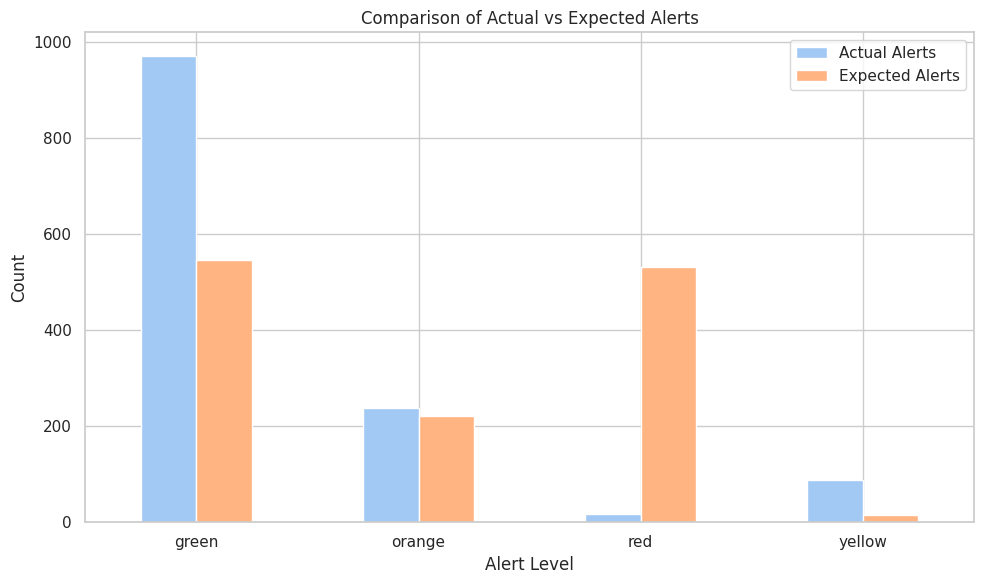

In [10]:
sns.set(style="whitegrid", palette="pastel")

# 1. Bar chart to compare actual vs expected alerts
def plot_alert_distributions(df):
    alert_counts = df['alert'].value_counts()
    expected_alert_counts = df['expected_alert'].value_counts()

    # DataFrame for easier comparison
    alert_comparison = pd.DataFrame({
        'Actual Alerts': alert_counts,
        'Expected Alerts': expected_alert_counts
    }).fillna(0)

    alert_comparison.plot(kind='bar', figsize=(10, 6))
    plt.title('Comparison of Actual vs Expected Alerts')
    plt.xlabel('Alert Level')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

plot_alert_distributions(df)

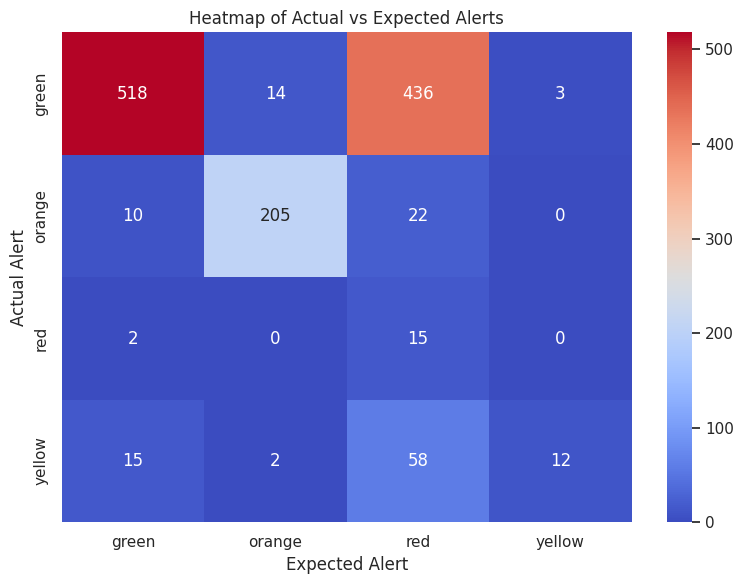

In [11]:
# 2. Heatmap of mismatches
def plot_mismatch_heatmap(df):
    # confusion matrix
    mismatch_matrix = pd.crosstab(df['alert'], df['expected_alert'])

    plt.figure(figsize=(8, 6))
    sns.heatmap(mismatch_matrix, annot=True, cmap="coolwarm", fmt='d', cbar=True)
    plt.title('Heatmap of Actual vs Expected Alerts')
    plt.xlabel('Expected Alert')
    plt.ylabel('Actual Alert')
    plt.tight_layout()
    plt.show()

plot_mismatch_heatmap(df)

# Alert Analysis

<ipython-input-12-34c591405f11>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='alert', y='magnitude', palette='coolwarm')
<ipython-input-12-34c591405f11>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='alert', y='sig', palette='coolwarm')


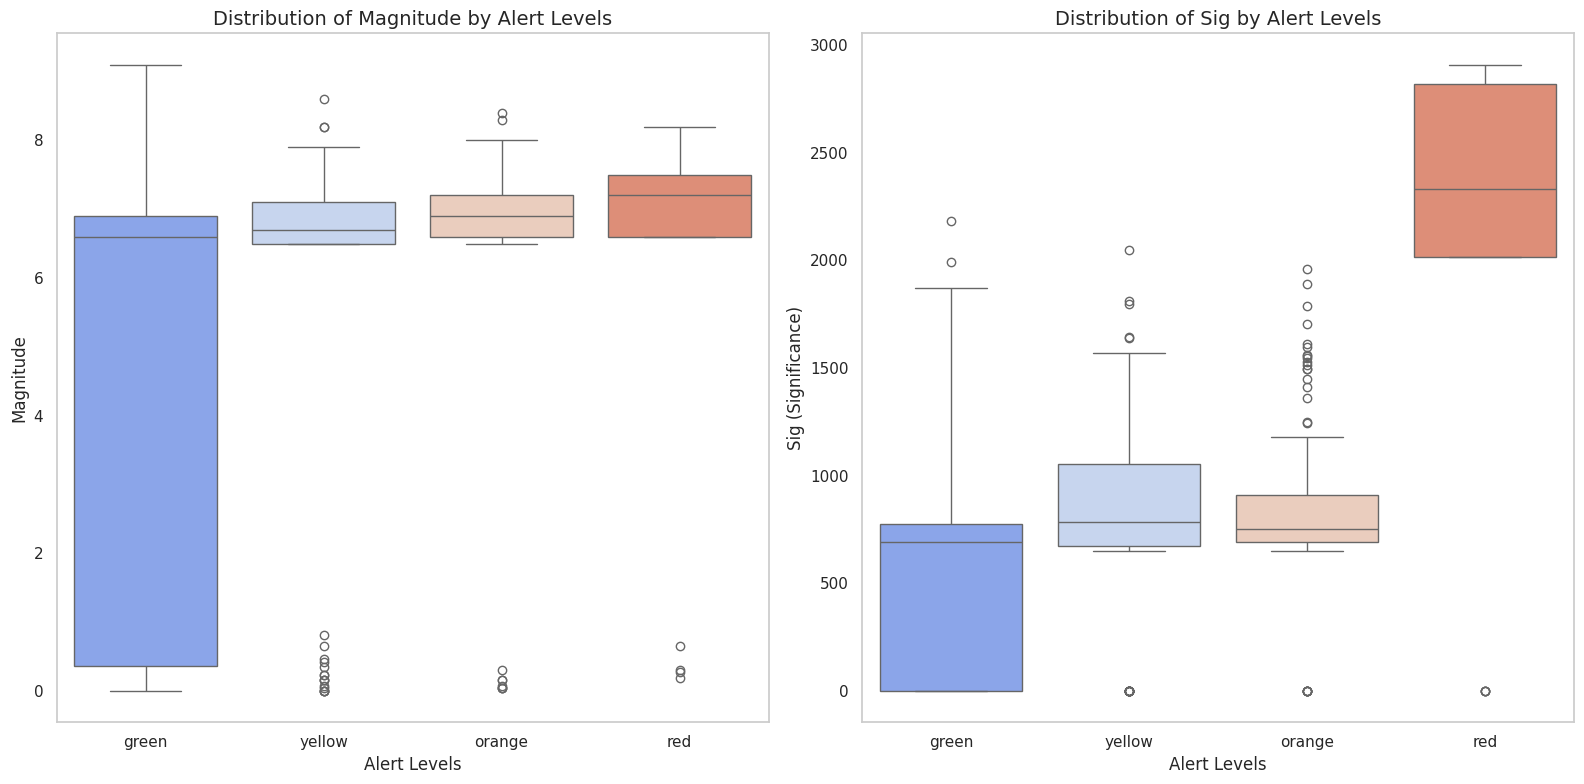

In [12]:
# Analyze distribution of alert levels with magnitude and sig
plt.figure(figsize=(16, 8))

# Plot 1: Magnitude by Alert Levels
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='alert', y='magnitude', palette='coolwarm')
plt.title('Distribution of Magnitude by Alert Levels', fontsize=14)
plt.xlabel('Alert Levels', fontsize=12)
plt.ylabel('Magnitude', fontsize=12)
plt.grid(axis='y')

# Plot 2: Sig by Alert Levels
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='alert', y='sig', palette='coolwarm')
plt.title('Distribution of Sig by Alert Levels', fontsize=14)
plt.xlabel('Alert Levels', fontsize=12)
plt.ylabel('Sig (Significance)', fontsize=12)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

In [13]:
# Map colors for the automated_alert column
alert_colors = {
    'green': 'green',
    'yellow': 'yellow',
    'orange': 'orange',
    'red': 'red'
}

# Adding a new column with color codes for plotting
df['alert_color'] = df['expected_alert'].map(alert_colors)

gdf = gpd.GeoDataFrame(df,
                       geometry=gpd.points_from_xy(df.longitude, df.latitude))

fig = px.scatter_geo(df,
                     lat='latitude',
                     lon='longitude',
                     color='alert_color',
                     color_discrete_map=alert_colors,
                     hover_name='title',
                     hover_data=['date_time', 'depth', 'magnitude', 'sig', 'cdi', 'mmi', 'country'],
                     title='Seismic Alert Levels by Location',
                     labels={'alert_color': 'Alert Level'},
                     template="plotly_dark")

# country borders
fig.update_geos(showland=True,
              landcolor="lightgray",
              showlakes=True,
              lakecolor="white",
              showcoastlines=True,
              coastlinecolor="black",
              countrycolor="black",
              projection_type="natural earth")

# map style
fig.update_geos(showland=True, landcolor="lightgray", showlakes=True, lakecolor="white")
fig.update_layout(showlegend=True)

fig.show()

# Strategies for optimized alerts

## Identify Sources of Gaps:
Analyzing the rows where mismatches occurred between alert and expected_alert. Focusing on the following aspects:

* Magnitude Ranges: Are mismatches higher for certain ranges of magnitudes?
* Community Determined Intensity (CDI): Are certain intensity values causing more mismatches?
* Depth: Is there a correlation between the depth of the earthquake and the mismatches?
* Tsunami Indicator: Are mismatches more frequent when a tsunami is indicated?

In [168]:
# Analyze mismatches based on key features
mismatch_analysis = df[df['gap'] == 1].groupby('expected_alert').agg({
    'magnitude': ['mean', 'max', 'min'],
    'depth': ['mean', 'max', 'min'],
    'cdi': ['mean', 'max', 'min'],
    'tsunami': 'sum'
}).reset_index()

display(mismatch_analysis)

expected_alert magnitude                depth                        cdi  \
                      mean  max  min       mean     max      min      mean   
0          green  3.156410  7.7  0.0  30.896890  231.00   0.0057  3.617284   
1         orange  6.812500  8.1  6.5  28.985625   49.00  20.0000  5.312500   
2            red  5.533465  9.1  0.0  57.701818  670.81   0.0012  4.073428   
3         yellow  6.666667  6.8  6.6  67.333333   96.00  50.0000  4.000000   

                 tsunami  
   max       min     sum  
0  9.0  0.333333     0.0  
1  8.0  0.000000     0.0  
2  9.0  0.000000   428.0  
3  4.0  4.000000     0.0